In [61]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import io

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

* https://www.kaggle.com/marklvl/sentiment-labelled-sentences-data-set
* sentiment (1 for positive, 0 for negative)

In [62]:
URL = 'https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P'
file_path = tf.keras.utils.get_file('sentiments.csv', URL)
print(file_path)

/root/.keras/datasets/sentiments.csv


In [63]:
dataset = pd.read_csv(file_path)
dataset.head()

,Unnamed: 0,text,sentiment
0,0,So there is no way for me to plug it in here i...,0
1,1,Good case Excellent value.,1
2,2,Great for the jawbone.,1
3,3,Tied to charger for conversations lasting more...,0
4,4,The mic is great.,1


In [64]:
sentences = dataset['text'].tolist()
labels = dataset['sentiment'].tolist()

len(sentences), len(labels)

(1992, 1992)

In [65]:
for i in range(2):
  print(sentences[i], labels[i])

So there is no way for me to plug it in here in the US unless I go by a converter. 0
Good case Excellent value. 1


# Creating subword dataset

In [66]:
VOCAB_SIZE = 1000

In [67]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(corpus_generator=sentences,
                                                                      target_vocab_size=VOCAB_SIZE,
                                                                      max_subword_length=5)
tokenizer

<SubwordTextEncoder vocab_size=999>

In [68]:
tokenizer.vocab_size

999

In [69]:
idx = 5
print(sentences[idx])

encoded = tokenizer.encode(sentences[idx])
print(encoded)

for i in encoded:
  print(i, ' --> ', tokenizer.decode([i]))

I have to jiggle the plug to get it to line up right to get decent volume.
[4, 31, 6, 849, 162, 450, 12, 1, 600, 438, 775, 6, 175, 14, 6, 55, 213, 159, 474, 775, 6, 175, 614, 380, 295, 148, 72, 789]
4  -->  I 
31  -->  have 
6  -->  to 
849  -->  j
162  -->  ig
450  -->  gl
12  -->  e 
1  -->  the 
600  -->  pl
438  -->  ug
775  -->   
6  -->  to 
175  -->  get 
14  -->  it 
6  -->  to 
55  -->  li
213  -->  ne 
159  -->  up 
474  -->  right
775  -->   
6  -->  to 
175  -->  get 
614  -->  dec
380  -->  ent 
295  -->  vo
148  -->  lu
72  -->  me
789  -->  .


# Replace sentences with encoded subwords

In [70]:
for i,sentence in enumerate(sentences):
  sentences[i] = tokenizer.encode(sentence)

In [71]:
print(sentences[0])

[736, 168, 775, 7, 193, 417, 17, 94, 6, 600, 438, 775, 14, 19, 141, 19, 1, 828, 826, 775, 99, 445, 4, 174, 361, 5, 79, 227, 139, 789]


# Splitting Dataset

In [72]:
MAX_LENGTH = 50
TRUNC_TYPE = 'post'
PADDING_TYPE = 'post'

In [73]:
padded_sentences = pad_sequences(sequences=sentences,
                                 maxlen=MAX_LENGTH,
                                 padding=PADDING_TYPE,
                                 truncating=TRUNC_TYPE)
padded_sentences[0]

array([736, 168, 775,   7, 193, 417,  17,  94,   6, 600, 438, 775,  14,
        19, 141,  19,   1, 828, 826, 775,  99, 445,   4, 174, 361,   5,
        79, 227, 139, 789,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [74]:
training_size = int(len(sentences) * 0.8)
training_size

1593

In [75]:
training_sequences = padded_sentences[:training_size]
testing_sequences = padded_sentences[training_size:]

training_labels = labels[:training_size]
testing_labels = labels[training_size:]

training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

len(training_sentences), len(training_labels), len(testing_sentences), len(testing_labels)

(1593, 1593, 399, 399)

# Creating Model with Embedding Layer

In [76]:
EMBEDDING_DIM = 16

In [77]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE,
                              EMBEDDING_DIM,
                              input_length=MAX_LENGTH),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [78]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [79]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 50, 16)            16000     
_________________________________________________________________
global_average_pooling1d_2 ( (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 102       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 7         
Total params: 16,109
Trainable params: 16,109
Non-trainable params: 0
_________________________________________________________________


In [80]:
NUM_EPOCHS = 30

history = model.fit(x=training_seuences,
                    y=training_labels_final,
                    epochs=NUM_EPOCHS,
                    validation_data=(testing_sequences, testing_labels_final))

Epoch 1/30
50/50 [==============================] - 1s 5ms/step - loss: 0.6901 - accuracy: 0.5229 - val_loss: 0.7008 - val_accuracy: 0.4311
Epoch 2/30
50/50 [==============================] - 0s 3ms/step - loss: 0.6842 - accuracy: 0.5474 - val_loss: 0.6965 - val_accuracy: 0.4737
Epoch 3/30
50/50 [==============================] - 0s 3ms/step - loss: 0.6752 - accuracy: 0.5913 - val_loss: 0.6903 - val_accuracy: 0.4987
Epoch 4/30
50/50 [==============================] - 0s 2ms/step - loss: 0.6608 - accuracy: 0.6190 - val_loss: 0.6718 - val_accuracy: 0.5890
Epoch 5/30
50/50 [==============================] - 0s 2ms/step - loss: 0.6369 - accuracy: 0.6981 - val_loss: 0.6645 - val_accuracy: 0.5464
Epoch 6/30
50/50 [==============================] - 0s 2ms/step - loss: 0.6064 - accuracy: 0.7370 - val_loss: 0.6395 - val_accuracy: 0.6341
Epoch 7/30
50/50 [==============================] - 0s 3ms/step - loss: 0.5660 - accuracy: 0.7910 - val_loss: 0.6132 - val_accuracy: 0.6792
Epoch 8/30
50/50 [==

In [81]:
model_loss_acc = model.evaluate(testing_sequences, testing_labels_final)
model_loss_acc

13/13 [==============================] - 0s 2ms/step - loss: 0.6259 - accuracy: 0.7594


[0.6259191036224365, 0.7593985199928284]

# Plot Accuracy & Loss Graph

In [82]:
def plot_graph(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

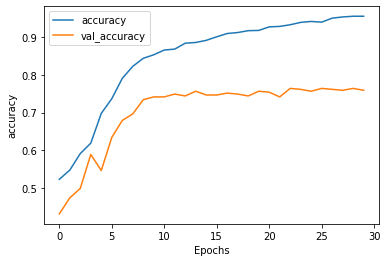

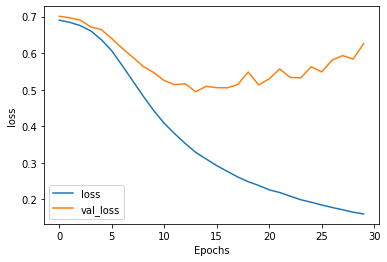

In [83]:
plot_graph(history, 'accuracy')
plot_graph(history, 'loss')


# Function to predict sentiment of review

In [84]:
def predict_review(model, new_sentences, maxlen=MAX_LENGTH, show_padded_sequence=True):
  new_sequences = []

  for i, sent in enumerate(new_sentences):
    new_sequences.append(tokenizer.encode(sent))

  TRUNC_TYPE = 'post'
  PADDING_TYPE = 'post'

  new_reviews_padded = pad_sequences(sequences=new_sequences,
                                    maxlen=maxlen,
                                    padding=PADDING_TYPE,
                                    truncating=TRUNC_TYPE)
  classes = model.predict(new_reviews_padded)

  for x in range(len(new_sentences)):
    if(show_padded_sequence):
      print(new_reviews_padded[x])
    print(new_sentences[x])
    print(classes[x])
    print('\n')


In [85]:
# Use the model to predict some reviews   
fake_reviews = ["I love this phone", 
                "Everything was cold",
                "Everything was hot exactly as I wanted", 
                "Everything was green", 
                "the host seated us immediately",
                "they gave us free chocolate cake", 
                "we couldn't hear each other talk because of the shouting in the kitchen"
              ]

predict_review(model, fake_reviews)


[  4 281  16  25   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
I love this phone
[0.9513852]


[812 227 864 100 775   9 525 843   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was cold
[0.12914357]


[812 227 864 100 775   9 109   8 333 731  24  61   4 171  59  77   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was hot exactly as I wanted
[0.40447378]


[812 227 864 100 775   9 157 359 853   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was green
[0.11892584]


[  1 109 228 540 237 635 24

# Function to fit model and show result

In [86]:
def fit_model(model, sentences):
  model.compile(
      loss = 'binary_crossentropy',
      optimizer = 'adam',
      metrics = ['accuracy']
  )
  model.summary()
  history = model.fit(x=training_sequences,
                      y=training_labels_final,
                      epochs=NUM_EPOCHS,
                      validation_data=(testing_sequences, testing_labels_final))
  return history
  

def plot_result(history):
  plot_graph(history, 'accuracy')
  plot_graph(history, 'loss')


def fit_model_and_show_result(model, sentences):
  history = fit_model(model, sentences)
  plot_result(history)
  predict_review(model, sentences)

# 1- Create a Bidirectional LSTM Model

In [87]:
model_bilstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE,
                              EMBEDDING_DIM,
                              input_length=MAX_LENGTH),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(EMBEDDING_DIM)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 50, 16)            16000     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 32)                4224      
_________________________________________________________________
dense_12 (Dense)             (None, 6)                 198       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 7         
Total params: 20,429
Trainable params: 20,429
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
50/50 [==============================] - 6s 50ms/step - loss: 0.6896 - accuracy: 0.5267 - val_loss: 0.6936 - val_accuracy: 0.4311
Epoch 2/30
50/50 [==============================] - 2s 33ms/step - loss: 0.6356 - accuracy: 0.6742 - val_lo

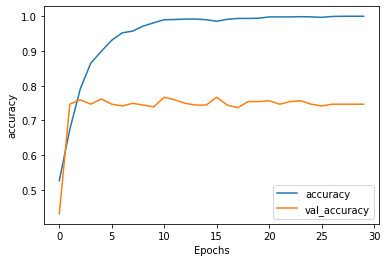

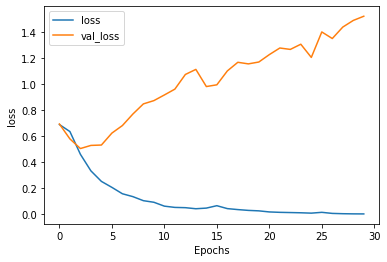

[  4 281  16  25   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
I love this phone
[0.99819696]


[812 227 864 100 775   9 525 843   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was cold
[0.0030379]


[812 227 864 100 775   9 109   8 333 731  24  61   4 171  59  77   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was hot exactly as I wanted
[0.9612433]


[812 227 864 100 775   9 157 359 853   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was green
[0.00284764]


[  1 109 228 540 237 635 241

In [88]:
fit_model_and_show_result(model_bilstm, fake_reviews)

# 2- Using Multiple Bidirectional Layers

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 50, 16)            16000     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 50, 32)            4224      
_________________________________________________________________
bidirectional_5 (Bidirection (None, 32)                6272      
_________________________________________________________________
dense_14 (Dense)             (None, 6)                 198       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 7         
Total params: 26,701
Trainable params: 26,701
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
50/50 [==============================] - 11s 91ms/step - loss: 0.6901 - accuracy: 0.5223 - val_loss: 0.70

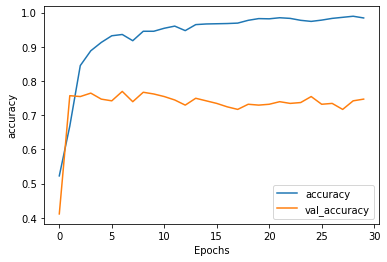

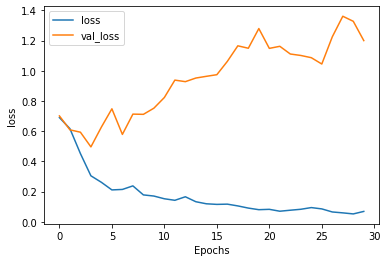

[  4 281  16  25   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
I love this phone
[0.99956286]


[812 227 864 100 775   9 525 843   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was cold
[0.02146316]


[812 227 864 100 775   9 109   8 333 731  24  61   4 171  59  77   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was hot exactly as I wanted
[0.02682146]


[812 227 864 100 775   9 157 359 853   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was green
[0.02163437]


[  1 109 228 540 237 635 2

In [90]:
model_multiple_bilstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE,
                              EMBEDDING_DIM,
                              input_length=MAX_LENGTH),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(EMBEDDING_DIM,
                                                       return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(EMBEDDING_DIM)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

fit_model_and_show_result(model_multiple_bilstm, fake_reviews)

# Comparing Models

In [91]:
my_reviews =["lovely", "dreadful", "stay away",
             "everything was hot exactly as I wanted",
             "everything was not exactly as I wanted",
             "they gave us free chocolate cake",
             "I've never eaten anything so spicy in my life, my throat burned for hours",
             "for a phone that is as expensive as this one I expect it to be much easier to use than this thing is",
             "we left there very full for a low price so I'd say you just can't go wrong at this place",
             "that place does not have quality meals and it isn't a good place to go for dinner",
             ]

In [92]:
print("===================================\n","Embeddings only:\n", "===================================",)
predict_review(model, my_reviews, show_padded_sequence=False)

 Embeddings only:
lovely
[0.9592228]


dreadful
[0.3448746]


stay away
[0.7398701]


everything was hot exactly as I wanted
[0.8499634]


everything was not exactly as I wanted
[0.6130969]


they gave us free chocolate cake
[0.8051297]


I've never eaten anything so spicy in my life, my throat burned for hours
[0.03714439]


for a phone that is as expensive as this one I expect it to be much easier to use than this thing is
[0.48336542]


we left there very full for a low price so I'd say you just can't go wrong at this place
[0.769148]


that place does not have quality meals and it isn't a good place to go for dinner
[0.882825]




In [93]:
print("===================================\n", "With a single bidirectional LSTM:\n", "===================================")
predict_review(model_bilstm, my_reviews, show_padded_sequence=False)

 With a single bidirectional LSTM:
lovely
[0.98561025]


dreadful
[0.0001812]


stay away
[0.00148198]


everything was hot exactly as I wanted
[0.9967135]


everything was not exactly as I wanted
[0.01300138]


they gave us free chocolate cake
[0.51109374]


I've never eaten anything so spicy in my life, my throat burned for hours
[0.00296354]


for a phone that is as expensive as this one I expect it to be much easier to use than this thing is
[0.63878554]


we left there very full for a low price so I'd say you just can't go wrong at this place
[0.9998163]


that place does not have quality meals and it isn't a good place to go for dinner
[0.9800097]




In [94]:
print("===================================\n","With two bidirectional LSTMs:\n", "===================================")
predict_review(model_multiple_bilstm, my_reviews, show_padded_sequence=False)

 With two bidirectional LSTMs:
lovely
[0.9995804]


dreadful
[0.01998544]


stay away
[0.02102163]


everything was hot exactly as I wanted
[0.9149488]


everything was not exactly as I wanted
[0.02362403]


they gave us free chocolate cake
[0.9994843]


I've never eaten anything so spicy in my life, my throat burned for hours
[0.0222697]


for a phone that is as expensive as this one I expect it to be much easier to use than this thing is
[0.02106303]


we left there very full for a low price so I'd say you just can't go wrong at this place
[0.99684644]


that place does not have quality meals and it isn't a good place to go for dinner
[0.8933327]


